In [14]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from scipy.ndimage import uniform_filter1d, sobel, prewitt, fourier_gaussian, fourier_shift

# EEG loading (EEGBCI dataset)

For thsi tutorial, we are going to use EEG data which is part of the MNE package. The information on the runs and tasks is summarized below:

|    Runs   |                 Task                |
|:----------|:------------------------------------|
| 1         | Baseline, eyes open                 |
| 2         | Baseline, eyes closed               |
| 3, 7, 11  | Motor execution: left vs right hand |
| 4, 8, 12  | Motor imagery: left vs right hand   |
| 5, 9, 13  | Motor execution: hands vs feet      |
| 6, 10, 14 | Motor imagery: hands vs feet        |

Information extracted from: [MNE docs](https://mne.tools/dev/generated/mne.datasets.eegbci.load_data.html#mne.datasets.eegbci.load_data)

We will start by loading the data into a usable matrix format (numpy). For this tutorial, we will focus on two tasks: motor imagery (left vs right) and motor imagery (hands vs feet). We will also focus only on the first subject (there are up to 109 unique identifiers).

In [2]:
# Define the parameters 
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

# Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
#Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
# Combine all loaded runs
raw_obj = concatenate_raws(raws)
motor_imagery_data = raw_obj.get_data()

runs = [4, 8, 12]  # use only motor execution (left vs right)

# Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
# Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
# Combine all loaded runs
raw_obj = concatenate_raws(raws)
motor_exec_data = raw_obj.get_data()


runs = 1  # use only motor execution (left vs right)

# Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
# Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
# Combine all loaded runs
raw_obj = concatenate_raws(raws)
base_open_data = raw_obj.get_data()

Extracting EDF parameters from /home/mariano/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., Cz.., C2.., C4.., C6.., Cp5., Cp3., Cp1., Cpz., Cp2., Cp4., Cp6., Fp1., Fpz., Fp2., Af7., Af3., Afz., Af4., Af8., F7.., F5.., F3.., F1.., Fz.., F2.., F4.., F6.., F8.., Ft7., Ft8., T7.., T8.., T9.., T10., Tp7., Tp8., P7.., P5.., P3.., P1.., Pz.., P2.., P4.., P6.., P8.., Po7., Po3., Poz., Po4., Po8., O1.., Oz.., O2.., Iz..
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/mariano/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Fc5., Fc3., Fc1., Fcz., Fc2., Fc4.

Now that we have the raw data loaded, we could plot the signals. In that case, we will only plot one channel (the first one) for simplicity.

<IPython.core.display.Javascript object>


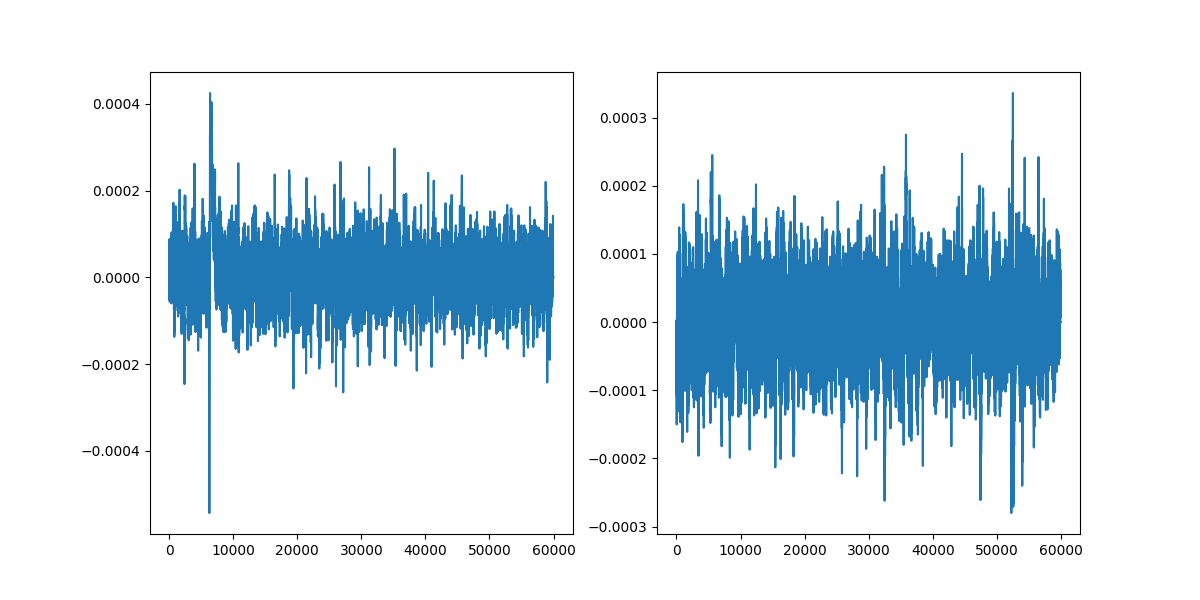

In [3]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
_ = plt.plot(motor_imagery_data.transpose()[:, 1])
plt.subplot(1, 2, 2)
_ = plt.plot(motor_exec_data.transpose()[:, 1])

As we can observe, these signals are fairly noisy. On solution to reduce the noise, would be to use a rolling mean. In that case, the rolling mean will be computed from the last 500 signal samples.

<IPython.core.display.Javascript object>


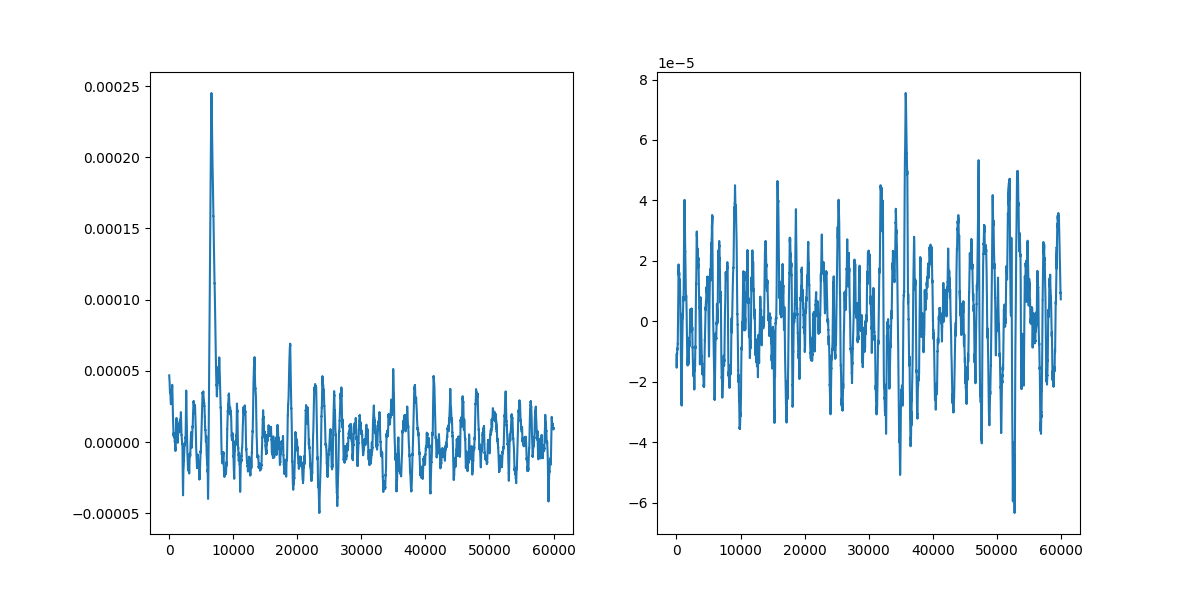

In [4]:
fmotor_imagery_data = np.stack([
    uniform_filter1d(signal, 500, mode='nearest')
    for signal in motor_imagery_data
])
fmotor_exec_data = np.stack([
    uniform_filter1d(signal, 500, mode='nearest')
    for signal in motor_exec_data
])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
_ = plt.plot(fmotor_imagery_data.transpose()[:, 1])
plt.subplot(1, 2, 2)
_ = plt.plot(fmotor_exec_data.transpose()[:, 1])

While a moving average can reduce the noise and give us a new timeseries, there are other moving functions we can use to generate features for a signal, that will then be used to condition our music generation algorithm. We will use Bottleneck to call some of them.

First we will check if the moving average still produces the same results with that package.

<IPython.core.display.Javascript object>


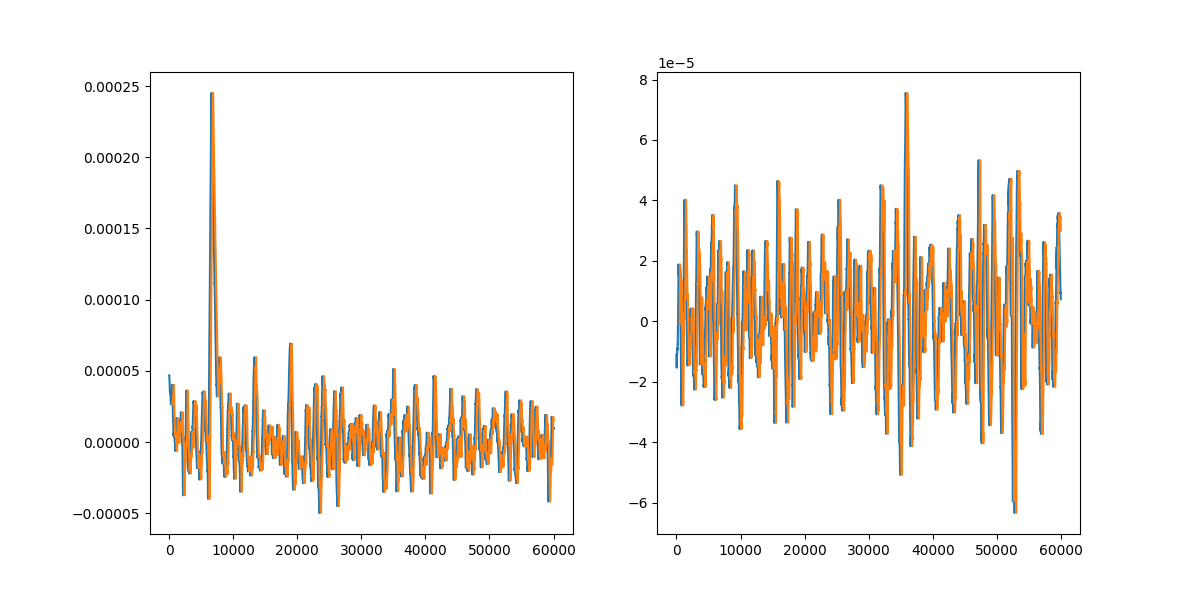

In [5]:
import bottleneck as bn
bmeanmotor_imagery_data = np.stack([
    bn.move_mean(signal, 500, axis=0)
    for signal in motor_imagery_data
])
bmeanmotor_exec_data = np.stack([
    bn.move_mean(signal, 500, axis=0)
    for signal in motor_exec_data
])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
_ = plt.plot(np.stack([
    fmotor_imagery_data.transpose()[:, 1],
    bmeanmotor_imagery_data.transpose()[:, 1]
], axis=1))
plt.subplot(1, 2, 2)
_ = plt.plot(np.stack([
    fmotor_exec_data.transpose()[:, 1],
    bmeanmotor_exec_data.transpose()[:, 1]
], axis=1))

How does it compare to the moving median?

<IPython.core.display.Javascript object>


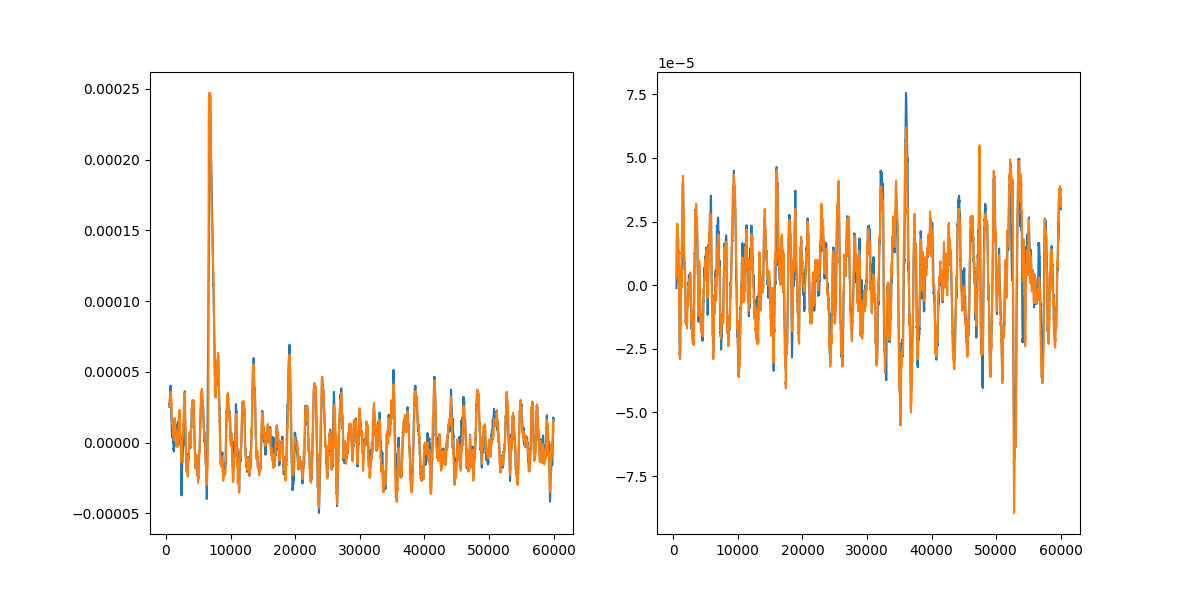

In [22]:
bmedianmotor_imagery_data = np.stack([
    bn.move_median(signal, 500, axis=0)
    for signal in motor_imagery_data
])
bmedianmotor_exec_data = np.stack([
    bn.move_median(signal, 500, axis=0)
    for signal in motor_exec_data
])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
_ = plt.plot(np.stack([
    bmeanmotor_imagery_data.transpose()[:, 1],
    bmedianmotor_imagery_data.transpose()[:, 1]
], axis=1))
plt.subplot(1, 2, 2)
_ = plt.plot(np.stack([
    bmeanmotor_exec_data.transpose()[:, 1],
    bmedianmotor_exec_data.transpose()[:, 1]
], axis=1))

Next we will check the moving min and max values together.

<IPython.core.display.Javascript object>


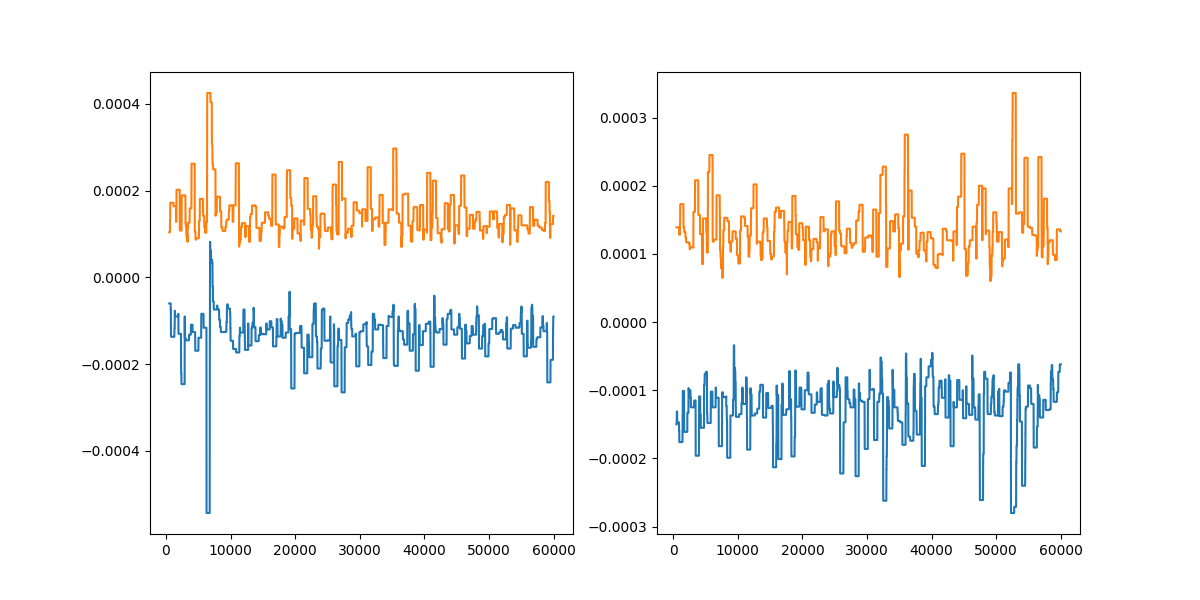

In [6]:
bminmotor_imagery_data = np.stack([
    bn.move_min(signal, 500, axis=0)
    for signal in motor_imagery_data
])
bminmotor_exec_data = np.stack([
    bn.move_min(signal, 500, axis=0)
    for signal in motor_exec_data
])
bmaxmotor_imagery_data = np.stack([
    bn.move_max(signal, 500, axis=0)
    for signal in motor_imagery_data
])
bmaxmotor_exec_data = np.stack([
    bn.move_max(signal, 500, axis=0)
    for signal in motor_exec_data
])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
_ = plt.plot(np.stack([
    bminmotor_imagery_data.transpose()[:, 1],
    bmaxmotor_imagery_data.transpose()[:, 1]
], axis=1))
plt.subplot(1, 2, 2)
_ = plt.plot(np.stack([
    bminmotor_exec_data.transpose()[:, 1],
    bmaxmotor_exec_data.transpose()[:, 1]
], axis=1))

Finally, we will compute the moving standard deviation and variance.

<IPython.core.display.Javascript object>


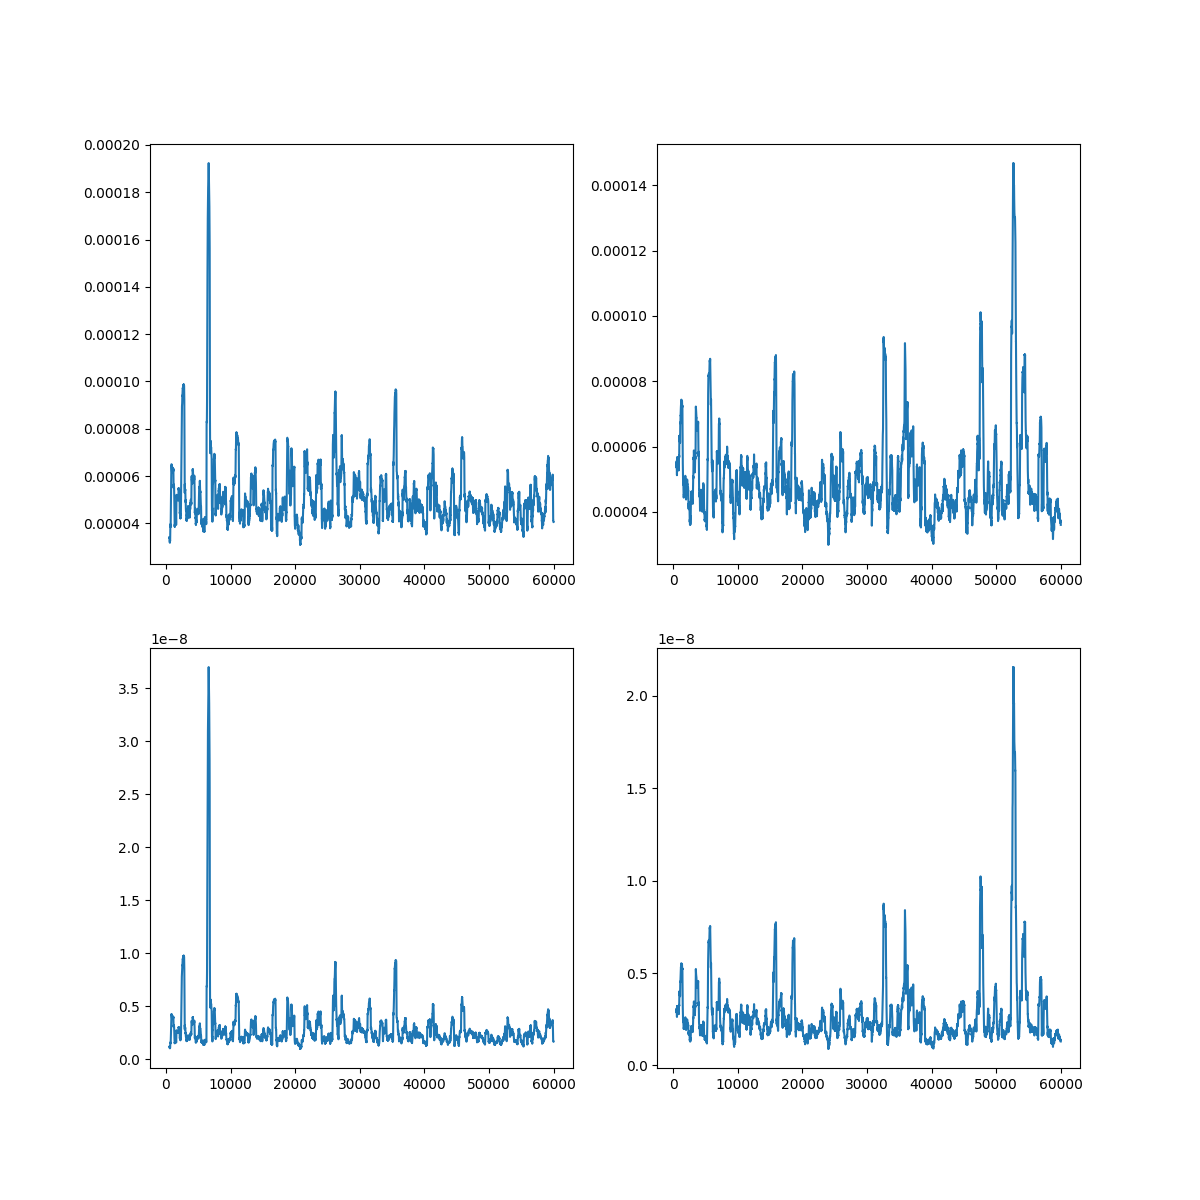

In [8]:
bstdmotor_imagery_data = np.stack([
    bn.move_std(signal, 500, axis=0)
    for signal in motor_imagery_data
])
bstdmotor_exec_data = np.stack([
    bn.move_std(signal, 500, axis=0)
    for signal in motor_exec_data
])
bvarmotor_imagery_data = np.stack([
    bn.move_var(signal, 500, axis=0)
    for signal in motor_imagery_data
])
bvarmotor_exec_data = np.stack([
    bn.move_var(signal, 500, axis=0)
    for signal in motor_exec_data
])

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
_ = plt.plot(bstdmotor_imagery_data.transpose()[:, 1])
plt.subplot(2, 2, 2)
_ = plt.plot(bstdmotor_exec_data.transpose()[:, 1])
plt.subplot(2, 2, 3)
_ = plt.plot(bvarmotor_imagery_data.transpose()[:, 1])
plt.subplot(2, 2, 4)
_ = plt.plot(bvarmotor_exec_data.transpose()[:, 1])

We can also include more complex operations from Scipy, such as sobel/prewitt filtering (for gradients) or fourier filtering. Here we present an example of Gaussian fourier filtering with different sigmas.

<IPython.core.display.Javascript object>


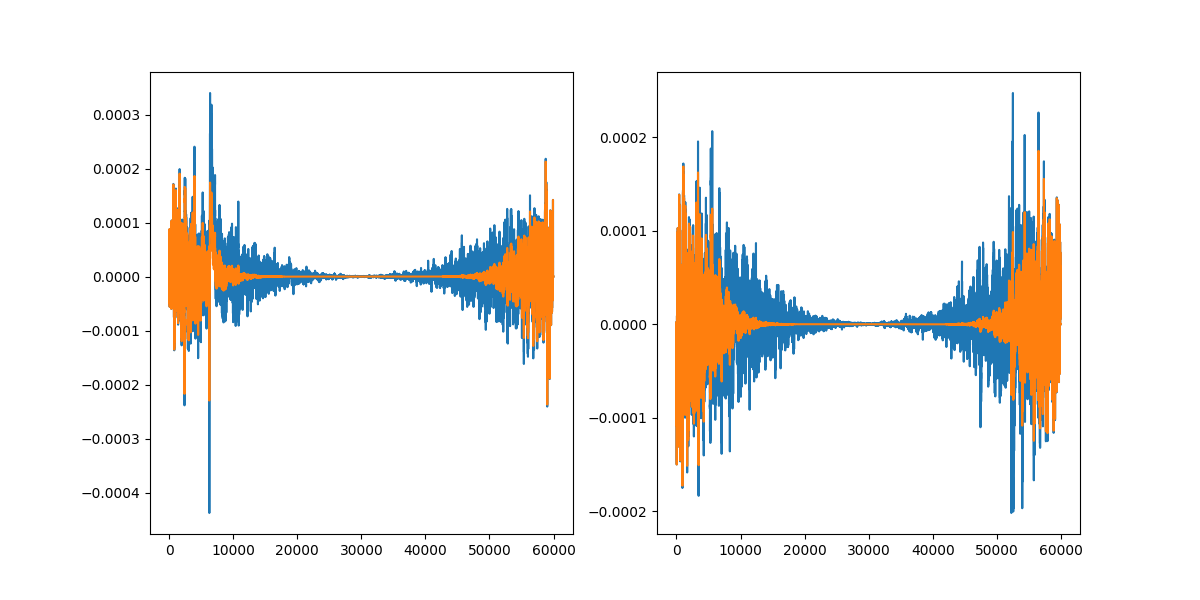

In [21]:
gauss1motor_imagery_data = np.stack([
    fourier_gaussian(signal, sigma=1, axis=0)
    for signal in motor_imagery_data
])
gauss1motor_exec_data = np.stack([
    fourier_gaussian(signal, sigma=1, axis=0)
    for signal in motor_exec_data
])
gauss2motor_imagery_data = np.stack([
    fourier_gaussian(signal, sigma=2, axis=0)
    for signal in motor_imagery_data
])
gauss2motor_exec_data = np.stack([
    fourier_gaussian(signal, sigma=2, axis=0)
    for signal in motor_exec_data
])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
_ = plt.plot(np.stack([
    gauss1motor_imagery_data.transpose()[:, 1],
    gauss2motor_imagery_data.transpose()[:, 1]
], axis=1))
plt.subplot(1, 2, 2)
_ = plt.plot(np.stack([
    gauss1motor_exec_data.transpose()[:, 1],
    gauss2motor_exec_data.transpose()[:, 1]
], axis=1))

These were just some non-exhaustive examples on how to create possible input vectors based on a single EEG signal. All of these function can be further combined together to generate new features. Furthermore, signal-wise function (for example general mean) can further be used to define features over the whole signal. Finally, there is also the option of defining your own filter with: scipy.ndimage.generic_filter1d.